In [1]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from skopt import BayesSearchCV
pd.set_option('display.max_columns', None)

C:\Users\abhir\anaconda3\envs\wildfire-data-mining\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_df=pd.read_csv("../Datasets/training_df_raw.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','time'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,10.4600,95.42882,9.7600,9.326071,0.0,0.0,0.0,0.0,0.0,1012.4,1012.03436,3.9,4.0,0.0,1.0,0.0,0.057978,7.421590,12.229406,112.833694,137.38599,11.879999,10.7600,13.110001,14.0100,21.910000,0.275,0.318,0.195,0.026,1
1,10.4535,95.42859,9.7535,9.317741,0.0,0.0,0.0,0.0,0.0,1012.4,1011.91230,3.9,4.0,0.0,1.0,0.0,0.057956,7.421590,12.229406,112.833694,137.38599,11.879999,10.7535,13.103500,14.0035,21.903500,0.275,0.318,0.195,0.026,1
2,10.4145,95.42721,9.7145,9.267784,0.0,0.0,0.0,0.0,0.0,1012.4,1011.18120,3.9,4.0,0.0,1.0,0.0,0.057823,7.421590,12.229406,112.833694,137.38599,11.879999,10.7145,13.064501,13.9645,21.864500,0.275,0.318,0.195,0.026,1
3,9.2235,99.66392,9.1735,8.143780,0.0,0.0,0.0,0.0,0.0,1012.5,1010.78680,2.7,3.0,0.0,0.0,0.0,0.003924,5.937272,11.885453,75.963730,125.13428,13.320000,10.4235,12.823500,13.7235,21.923500,0.273,0.324,0.201,0.020,1
4,9.2430,99.66399,9.1930,8.168585,0.0,0.0,0.0,0.0,0.0,1012.5,1011.15370,2.7,3.0,0.0,0.0,0.0,0.003929,5.937272,11.885453,75.963730,125.13428,13.320000,10.4430,12.842999,13.7430,21.942999,0.273,0.324,0.201,0.020,1


In [3]:
training_df.shape

(113896, 31)

<Axes: >

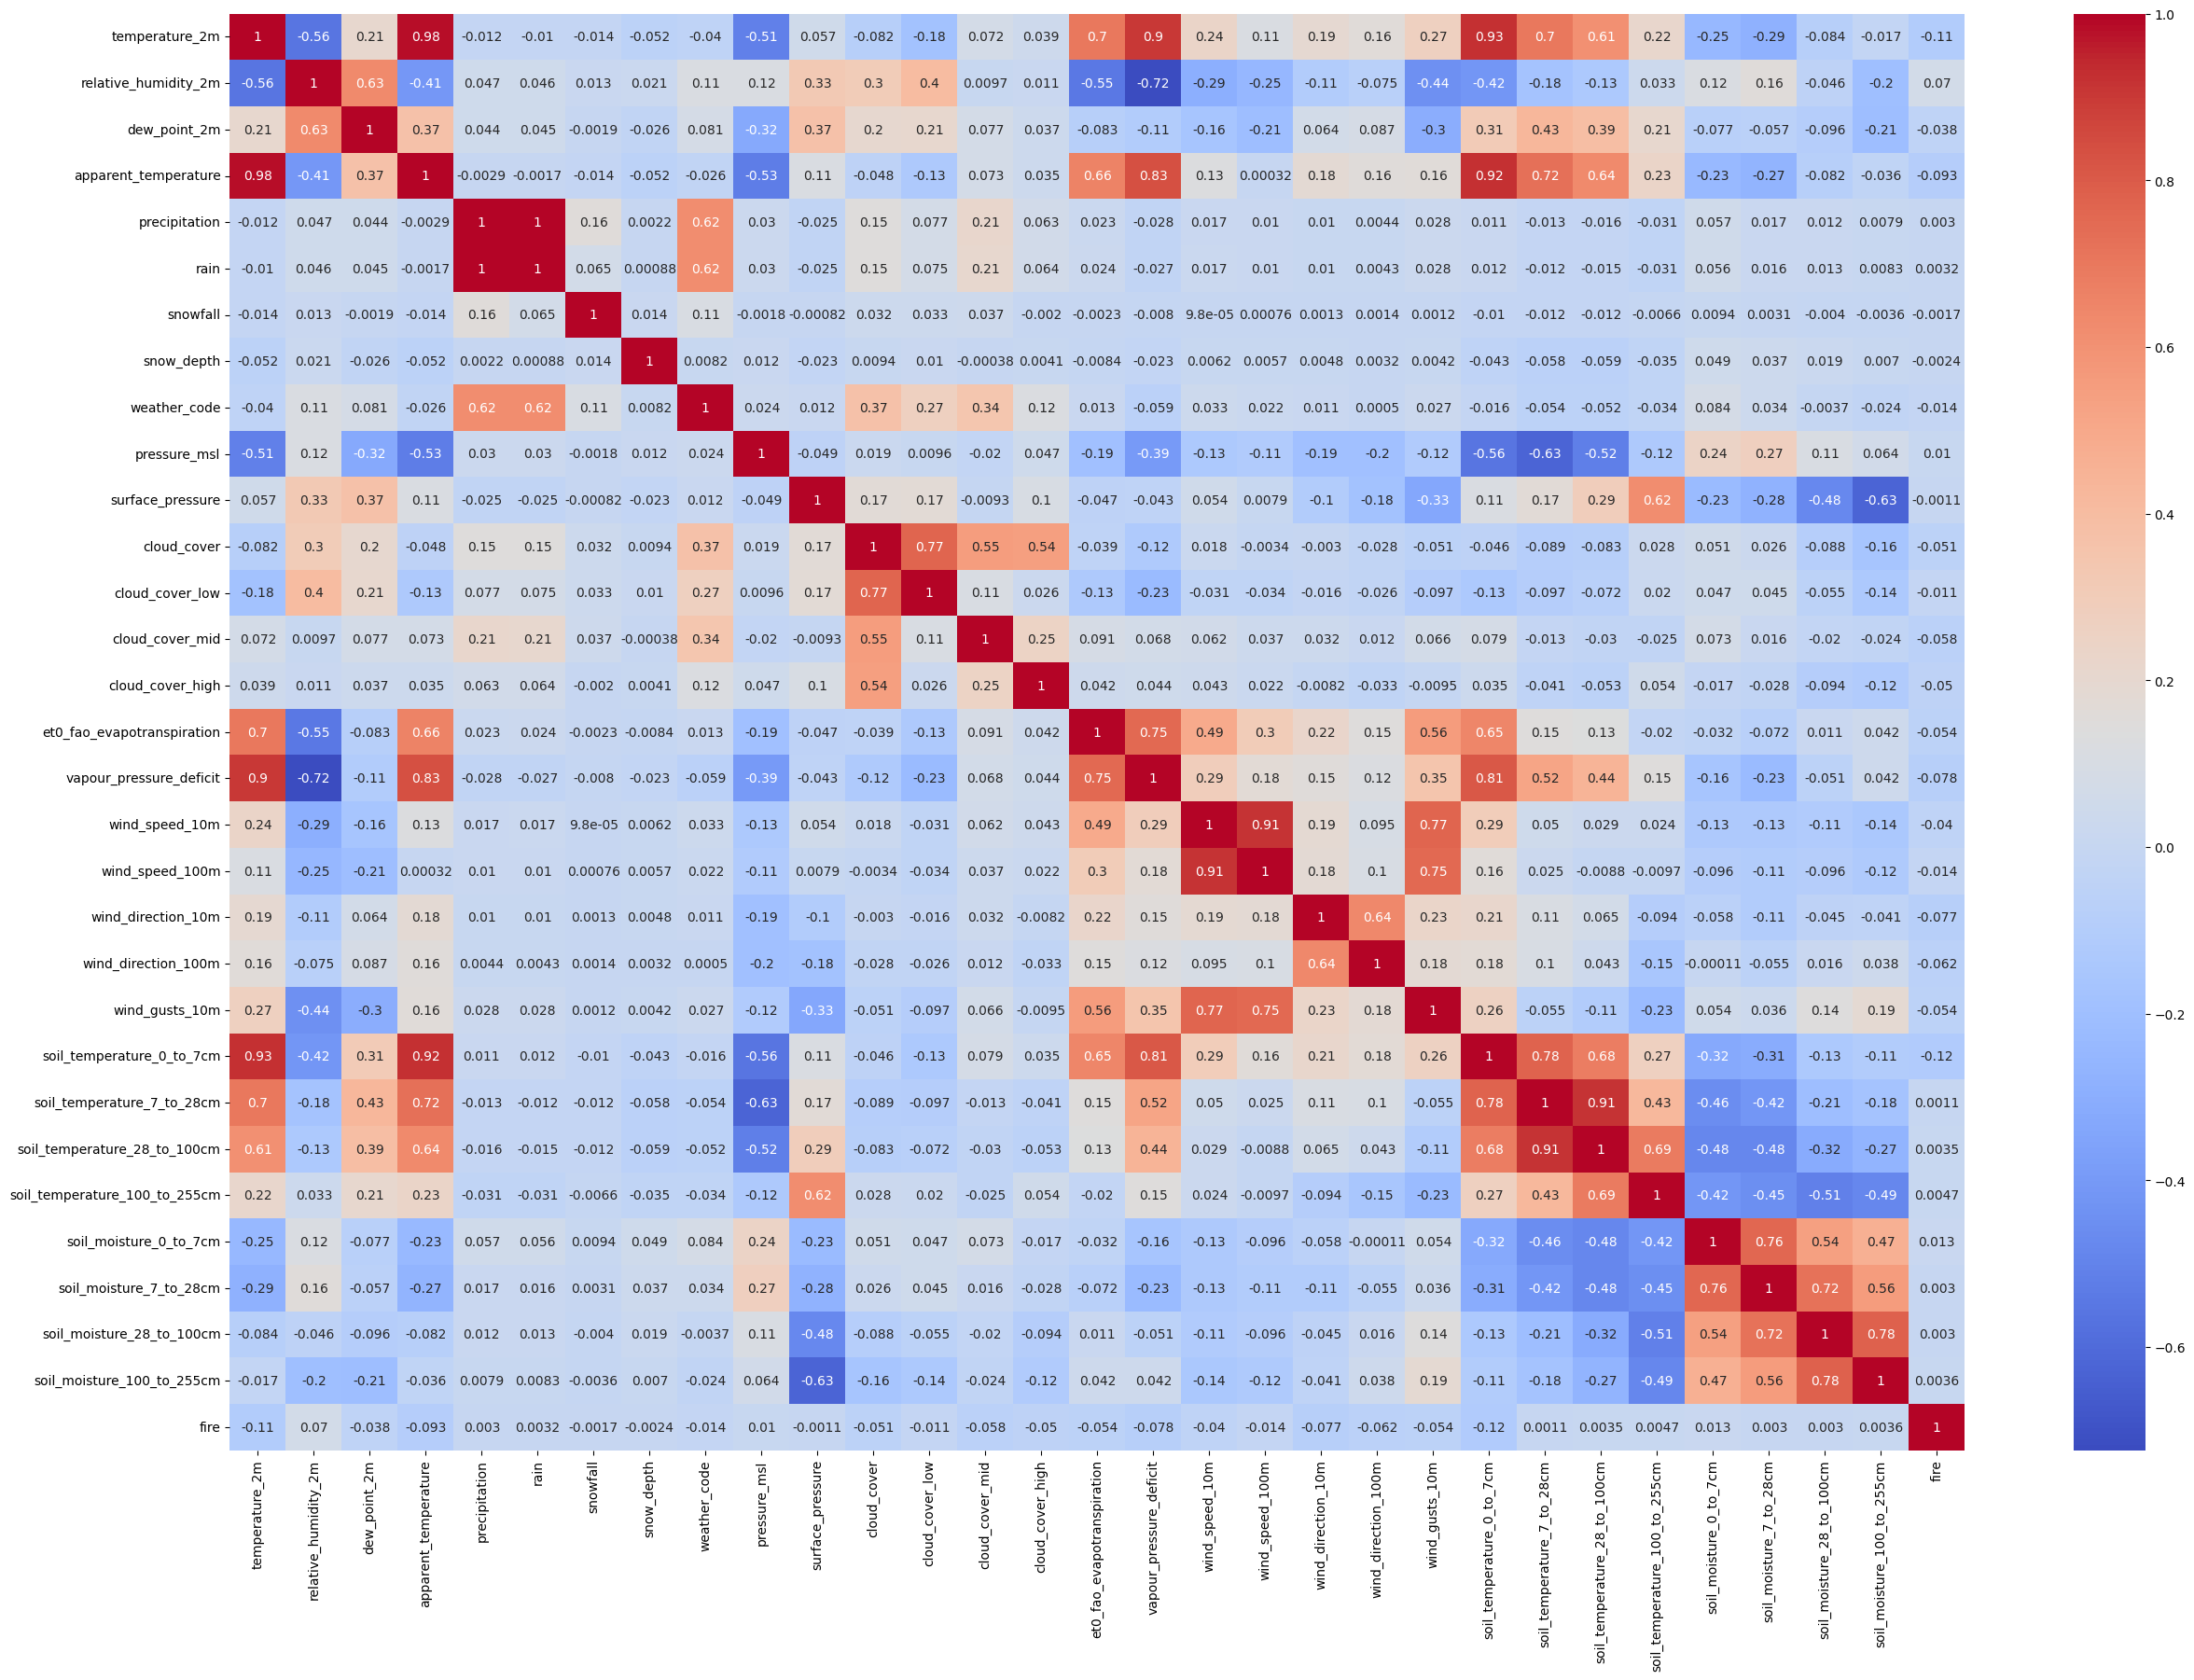

In [4]:
plt.figure(figsize=(30, 20))
correlation_matrix = training_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")


In [5]:
high_corr = np.where((correlation_matrix > 0.9) | (correlation_matrix < -0.9))

high_corr_pairs = []
for i in range(len(high_corr[0])):
    row = high_corr[0][i]
    col = high_corr[1][i]
    if row != col:  # Ignore self-correlation
        high_corr_pairs.append((training_df.columns[row], training_df.columns[col], correlation_matrix.iloc[row, col]))

high_corr_pairs


[('temperature_2m', 'apparent_temperature', np.float64(0.9799347105076525)),
 ('temperature_2m', 'vapour_pressure_deficit', np.float64(0.9043904706407196)),
 ('temperature_2m',
  'soil_temperature_0_to_7cm',
  np.float64(0.9259084204954837)),
 ('apparent_temperature', 'temperature_2m', np.float64(0.9799347105076525)),
 ('apparent_temperature',
  'soil_temperature_0_to_7cm',
  np.float64(0.9212335040153579)),
 ('precipitation', 'rain', np.float64(0.995669439181336)),
 ('rain', 'precipitation', np.float64(0.995669439181336)),
 ('vapour_pressure_deficit', 'temperature_2m', np.float64(0.9043904706407196)),
 ('wind_speed_10m', 'wind_speed_100m', np.float64(0.9136265152399176)),
 ('wind_speed_100m', 'wind_speed_10m', np.float64(0.9136265152399176)),
 ('soil_temperature_0_to_7cm',
  'temperature_2m',
  np.float64(0.9259084204954837)),
 ('soil_temperature_0_to_7cm',
  'apparent_temperature',
  np.float64(0.9212335040153579)),
 ('soil_temperature_7_to_28cm',
  'soil_temperature_28_to_100cm',
  

In [6]:
features_to_drop = [
    'snow_depth', 
    'weather_code',  
    'precipitation', 
    'rain', 
    'wind_speed_100m',
    'apparent_temperature',
    'soil_temperature_28_to_100cm',
    'snowfall'
]


training_df.drop(columns=features_to_drop, inplace=True)

print(training_df.columns)

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'snowfall',
       'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low',
       'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'fire'],
      dtype='object')


In [7]:
training_df.shape

(113896, 24)

In [8]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
scaler = StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [11]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

In [12]:
xgb_cv_scores  = cross_val_score(xgb_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

print("XGBoost Cross-Validation Scores: ", xgb_cv_scores)
print("XGBoost Mean Accuracy: ", np.mean(xgb_cv_scores))


XGBoost Cross-Validation Scores:  [0.82429763 0.82050156 0.82105032 0.82412336 0.82522087]
XGBoost Mean Accuracy:  0.8230387499574221


In [13]:
xgb_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
# Get feature importance values
importance = xgb_model.get_booster().get_score(importance_type='weight')
print(importance)


{'f0': 183.0, 'f1': 268.0, 'f2': 183.0, 'f4': 307.0, 'f5': 302.0, 'f6': 122.0, 'f7': 30.0, 'f8': 64.0, 'f9': 97.0, 'f10': 544.0, 'f11': 177.0, 'f12': 423.0, 'f13': 330.0, 'f14': 285.0, 'f15': 327.0, 'f16': 391.0, 'f17': 363.0, 'f18': 225.0, 'f19': 215.0, 'f20': 145.0, 'f21': 159.0, 'f22': 219.0}


In [15]:
feature_columns = X.columns.tolist()

importance_dict = {'f0': 183.0, 'f1': 268.0, 'f2': 183.0, 'f4': 307.0, 'f5': 302.0, 'f6': 122.0, 'f7': 30.0, 'f8': 64.0, 'f9': 97.0, 'f10': 544.0, 'f11': 177.0, 'f12': 423.0, 'f13': 330.0, 'f14': 285.0, 'f15': 327.0, 'f16': 391.0, 'f17': 363.0, 'f18': 225.0, 'f19': 215.0, 'f20': 145.0, 'f21': 159.0, 'f22': 219.0}

# Map feature names to actual columns
feature_importance_mapping = {feature_columns[int(f[1:])]: importance for f, importance in importance_dict.items()}

# Check the mapping
print(feature_importance_mapping)


{'temperature_2m': 183.0, 'relative_humidity_2m': 268.0, 'dew_point_2m': 183.0, 'pressure_msl': 307.0, 'surface_pressure': 302.0, 'cloud_cover': 122.0, 'cloud_cover_low': 30.0, 'cloud_cover_mid': 64.0, 'cloud_cover_high': 97.0, 'et0_fao_evapotranspiration': 544.0, 'vapour_pressure_deficit': 177.0, 'wind_speed_10m': 423.0, 'wind_direction_10m': 330.0, 'wind_direction_100m': 285.0, 'wind_gusts_10m': 327.0, 'soil_temperature_0_to_7cm': 391.0, 'soil_temperature_7_to_28cm': 363.0, 'soil_temperature_100_to_255cm': 225.0, 'soil_moisture_0_to_7cm': 215.0, 'soil_moisture_7_to_28cm': 145.0, 'soil_moisture_28_to_100cm': 159.0, 'soil_moisture_100_to_255cm': 219.0}


In [16]:
y_train_pred_xgb = xgb_model.predict(X_train_transformed)

train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Training Accuracy: 86.79%


Accuracy: 83.14%
Precision: 83.96%
Recall: 83.14%
F1 Score: 83.02%


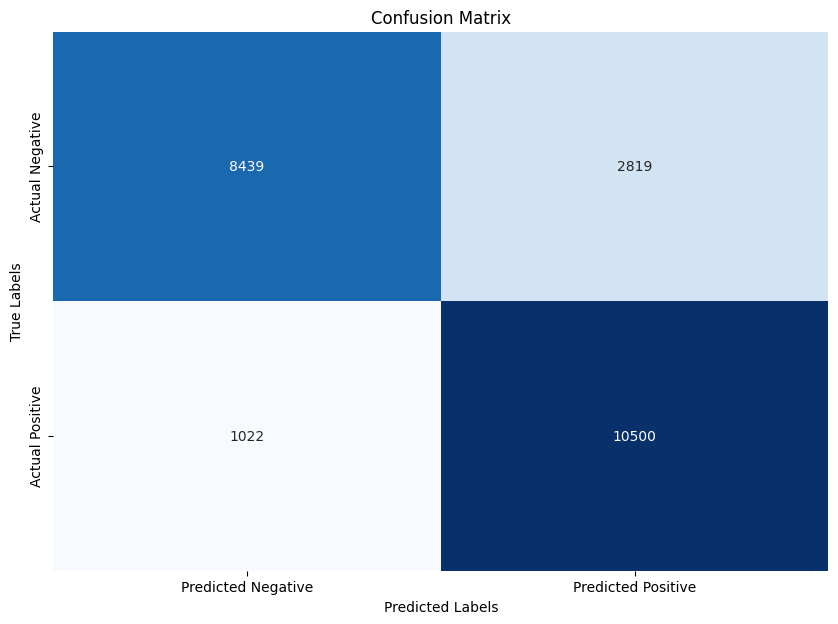

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81     11258
           1       0.79      0.91      0.85     11522

    accuracy                           0.83     22780
   macro avg       0.84      0.83      0.83     22780
weighted avg       0.84      0.83      0.83     22780



In [17]:
y_pred_xgb = xgb_model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(y_test, y_pred_xgb, average='weighted')
recall = recall_score(y_test, y_pred_xgb, average='weighted')
f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_xgb)
print('Classification Report:')
print(class_report)


In [18]:
xgb_model = xgb.XGBClassifier()

search_space_xgb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 5),
}

bayes_search_xgb = BayesSearchCV(estimator=xgb_model, search_spaces=search_space_xgb, cv=5, n_jobs=-1, verbose=2)

bayes_search_xgb.fit(X_train_transformed, y_train)

print(f"Best parameters: {bayes_search_xgb.best_params_}")
print(f"Best cross-validation score: {bayes_search_xgb.best_score_}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [19]:
best_xgboost_model = xgb.XGBClassifier(
    learning_rate=bayes_search_xgb.best_params_['learning_rate'],
    max_depth=bayes_search_xgb.best_params_['max_depth'],
    n_estimators=bayes_search_xgb.best_params_['n_estimators'],
    subsample=bayes_search_xgb.best_params_['subsample'],
    colsample_bytree=bayes_search_xgb.best_params_['colsample_bytree'],
    gamma=bayes_search_xgb.best_params_['gamma']
)

best_xgboost_model.fit(X_train_transformed, y_train)

y_train_pred_xgb = best_xgboost_model.predict(X_train_transformed)

train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Training Accuracy: 97.81%


Accuracy: 87.29%
Precision: 83.76%
Recall: 92.88%
F1 Score: 88.09%


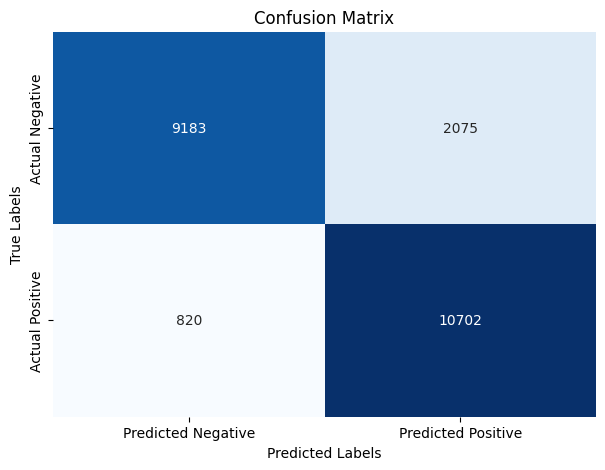

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.86     11258
           1       0.84      0.93      0.88     11522

    accuracy                           0.87     22780
   macro avg       0.88      0.87      0.87     22780
weighted avg       0.88      0.87      0.87     22780



In [20]:
y_pred_xgb = best_xgboost_model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_xgb)
print('Classification Report:')
print(class_report)


In [21]:
importances = best_xgboost_model.feature_importances_
feature_names=X.columns
feature_imp_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
10,et0_fao_evapotranspiration,0.096188
17,soil_temperature_7_to_28cm,0.071194
16,soil_temperature_0_to_7cm,0.069240
8,cloud_cover_mid,0.050913
12,wind_speed_10m,0.050840
1,relative_humidity_2m,0.046630
5,surface_pressure,0.045443
19,soil_moisture_0_to_7cm,0.044141
15,wind_gusts_10m,0.040218
22,soil_moisture_100_to_255cm,0.038742


In [22]:
y_scores = best_xgboost_model.predict_proba(X_test_transformed)[:, 1]

AUC-ROC Score: 0.9379949921780633


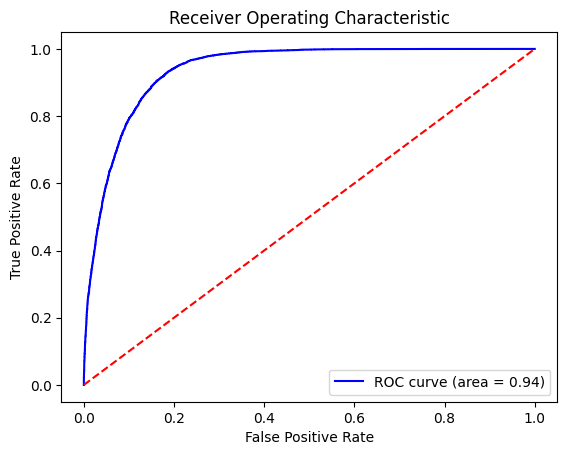

In [23]:
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()